In [1]:
%matplotlib inline

import sys, os
import itertools
import collections

import tensorflow as tf
import numpy as np

import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
import scipy
from scipy import optimize

import time
import datetime

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style("whitegrid")
#current_palette = sns.color_palette()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: F

In [2]:
# checking device
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
from thurner_model import NoiseTrader, Fund, DynamicFund, find_equilibrium 
import plotting

In [4]:
class Env:
    """
    Docstring
    """
    # Define our fundamental value V and asset-supply N
    V = 1.
    N = 1000.
    
    initial_price = 1.
    
    # Define noise trader (NoiseTrader Class defined in thurner_model.py)
    roh_nt = 0.99
    sigma_nt = 0.035
    noise_trader = NoiseTrader(roh_nt, sigma_nt, V, N)
    initial_nt_spending = V*N
    
    def __init__(self):
        # tracks trader spending
        
        self.p_t = self.initial_price
        self.xi_t = self.initial_nt_spending
        self.done = False 
        
    # when resetting the environment, we set the state back to the initial one 
    def reset(self):
        self.p_t = self.initial_price
        self.xi_t = self.initial_nt_spending

    def step(self, funds):
        """Finds equilibrium, and updates environment parameters""" 
        # track the old price for the investor mechanism
        p_tm1 = self.p_t
        
        # 1. Find the new price for the timestep
        self.xi_t = self.noise_trader.cash_spending(self.xi_t)
        self.p_t = find_equilibrium(self.xi_t, funds)
    
        # 2. update the holdings of all the funds (wealth, shares and cash)
        current_wealth = []
        
        for fund in funds:
            fund.update_holdings(self.p_t)
            fund.check_and_make_bankrupt(self.p_t)
            
            fund.process_inflows(p_tm1, self.p_t)
            
            new_wealth_of_fund = fund.get_wealth(self.p_t)
            current_wealth.append(new_wealth_of_fund)
            
            # set done to True if one fund increases its wealth 50-fold
            if new_wealth_of_fund > 50*fund.initial_wealth:
                self.done = True
                
        return current_wealth

In [5]:
env = Env()

In [6]:
# Create examples for observations to train the featurizer
tracked_fund = DynamicFund(25)
other_funds = [DynamicFund((i+1)*5) for i in range(9)]
other_funds.append(tracked_fund)
#print([f.beta for f in other_funds])

states = np.zeros((10000,2))
for i in range(10000):
    current_wealth = env.step(other_funds)
    states[i] = np.array([env.p_t,
                          tracked_fund.get_wealth(env.p_t)
                         ])
    # record the state of the fund

[5, 10, 15, 20, 25, 30, 35, 40, 45, 25]


In [7]:
# (By Denny Britz)
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this

observation_examples = states 
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurized represenation.
# We use RBF kernels with different variances to cover different parts
# of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
#print(featurizer.fit(scaler.transform(observation_examples)))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)


In [8]:
def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

In [9]:
class LearningFund(DynamicFund):
    """
    Description: Base Class is DynamicFund, defined in thurner_model.py
    The Learning Fund learns its demand function via reinforcement learning
    """
    
    def __init__(self):
        # The learning fund does not need a beta, but learns how to leverage
        self.leverage = 0
        
        self.cash = self.initial_wealth
        self.shares = 0 
        self.activation_delay = 0
        
        self.performance = 0.0
        self.previous_wealth = self.initial_wealth
        self.previous_investment = 0.0
   
    def get_state(self, p_t):
        # The state is composed of the current price, as well as the current
        # holdings of the fund
        state = np.array([p_t,
                          self.get_wealth(p_t)])
        return state

    def get_demand(self, p_t):
        """
        Args:
            p_t : current_price in the environment
        Returns:
            A number for the learning_fund's demand, estimated by the
            policy_estimator, based on the current state
        """ 
        state = self.get_state(p_t)
        
        self.leverage = policy_estimator.predict(state)
        
        return self.leverage * self.get_wealth(p_t) / p_t 

In [10]:
class PolicyEstimator():
    """
    Policy Function approximator. Also called Actor.
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            tf.contrib.layers.fully_connected()
            
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            self.normal_dist = tf.contrib.distributions.Normal(self.mu,
                                                               self.sigma)
            self.leverage = self.normal_dist._sample_n(1)
            
            # clip the leverage, maximum leverage is given by:
            max_leverage = learning_fund.lambda_max 
                
            self.leverage = tf.clip_by_value(self.leverage, 0, max_leverage)

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.leverage) * self.target
            # Add cross entropy cost to encourage exploration
            self.loss -= 1e-1 * self.normal_dist.entropy()
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.train.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.leverage, { self.state: state })

    def update(self, state, target, leverage, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state,
                      self.target: target,
                      self.leverage: leverage  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [11]:
class ValueEstimator():
    """
    Value Function approximator. Also called Critic.
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just a linear classifier
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.train.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [12]:
def actor_critic(env, policy_estimator, value_estimator, num_episodes, num_timesteps=5000, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: My self created environment, specified above.
        policy_estimator: Policy Function to be optimized 
        value_estimator: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and
        episode_rewards.
    """
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action",
                                                       "reward", "next_state",
                                                       "done"])
    
    funds_wealth_all_episodes = []
    
    learning_fund_stats = np.zeros((num_episodes, num_timesteps, 5))
    
    for i_episode in range(num_episodes):
        
        # Reset everything
        prices = []
        funds_wealth = []

        # Create our learning_fund
        learning_fund = LearningFund()
        
        # Create the funds 
        number_of_funds = 10
        funds = [DynamicFund((i+1)*5) for i in range(number_of_funds)]
        
        # Add our learning fund
        funds.append(learning_fund)

        # Reset the environment 
        env.reset() 
        
        episode = []
        
        # One step in the environment
        for t in range(num_timesteps):
            
            # get the demand (which is our action) of the learning fund
            demand = learning_fund.get_demand(env.p_t) 
            
            state = learning_fund.get_state(env.p_t)
            
            # Simulate a step in the environment,
            # record the wealth of all funds in current_wealth
            current_wealth = env.step(funds)
            
            # record the wealth of all funds and the current price
            funds_wealth.append(current_wealth)
            prices.append(env.p_t)
            
            # we assume one learning fund for the moment
            next_state = learning_fund.get_state(env.p_t) 

            reward = learning_fund.performance
            
            # Keep track of the transition
            episode.append(Transition(state=state, action=demand,
                                      reward=reward, next_state=next_state,
                                      done=env.done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = value_estimator.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - value_estimator.predict(state)
            
            # Update the value estimator
            value_estimator.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            policy_estimator.update(state, td_error, demand)
            
            learning_fund_stats[i_episode][t] = np.array([env.p_t,
                                                          demand,
                                                          learning_fund.get_wealth(env.p_t),
                                                          learning_fund.cash,
                                                          learning_fund.shares])
            
            # Print out which step we're on, useful for debugging.
            print("\rt: {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes,
                    stats.episode_rewards[i_episode - 1]), end="")
            
            #if t%500 == 0:
            #    print("P_t: ", env.p_t)
            #    print("Demand: ", demand)
            #    print("Shares:", learning_fund.shares)
            #    print("Reward:", learning_fund.performance, "\n")
            #    print(funds[5].get_demand(env.p_t))
            #    print(funds[5].shares)
            #    print(funds[5].performance)
            #    print("")
                        
            # env.done is True if one fund increases its wealth 50-fold
            if env.done:
                break
            
            state = next_state

        # After each episode, record the wealth of all funds
        funds_wealth_all_episodes.append(funds_wealth)
    
        # Save the variables to disk.
        if episode_i % 19 == 0:
            checkpoint = "./checkpoints/{}-ep{}".format(experiment_name,i_episode)
            save_path = saver.save(sess,checkpoint)         
            print("\nModel saved in path: {}\n".format(save_path))
    
    return stats, funds_wealth_all_episodes, learning_fund_stats

In [13]:
print("\n########## Starting Learning Process ##########\n")
print(datetime.datetime.now().time(), "\n")

# Before running, always set experiment name
experiment_name = "fund_learns_leverage"

episodes = 30
timesteps = 5000 #max per episode

start_time = time.time()

experiment_name = "{}".format(experiment_name)

# make a directory to save our learned model variables
%mkdir checkpoints

# Create the environment
env = Env()

# first initialization of our learning fund
learning_fund = LearningFund()

##############################################################################
# This works
tf.reset_default_graph()

policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator(learning_rate=0.1)

# Add an op to initialize the variables.
init_op = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver(max_to_keep=1)

with tf.Session() as sess:
    sess.run(init_op)
    # Due to randomness in the policy, the number of episodes you need varies
    # TODO: Sometimes the algorithm gets stuck, I'm not sure what exactly is
    # happening there.
    stats,funds_wealth_all_episodes,learnin_fund_stats = actor_critic(env, policy_estimator,
                                                                      value_estimator,num_episodes=episodes,
                                                                      num_timesteps=timesteps, discount_factor=0.95)
    
print("\nDuration: {} min".format((time.time() - start_time)/60))




########## Starting Learning Process ##########

09:22:52.097227 

mkdir: cannot create directory ‘checkpoints’: File exists
t: 4999 @ Episode 1/30 (0.0)
Model saved in path: ./checkpoints/fund_learns_leverage-ep0

t: 4999 @ Episode 2/30 (5.083521842956543)
Model saved in path: ./checkpoints/fund_learns_leverage-ep1

t: 4999 @ Episode 3/30 (-5.299295902252197)
Model saved in path: ./checkpoints/fund_learns_leverage-ep2

t: 4999 @ Episode 4/30 (0.16134598851203918)
Model saved in path: ./checkpoints/fund_learns_leverage-ep3

t: 4999 @ Episode 5/30 (3.384481430053711)
Model saved in path: ./checkpoints/fund_learns_leverage-ep4

t: 4999 @ Episode 6/30 (-0.9002842307090759)
Model saved in path: ./checkpoints/fund_learns_leverage-ep5

t: 4999 @ Episode 7/30 (4.105498790740967)
Model saved in path: ./checkpoints/fund_learns_leverage-ep6

t: 4999 @ Episode 8/30 (0.16265003383159637)
Model saved in path: ./checkpoints/fund_learns_leverage-ep7

t: 4999 @ Episode 9/30 (0.709623396396637)
Model 

In [15]:
import pickle
# save data from experiment
%mkdir data

# Saving the objects:
path = "./data/"
filename = "{}{}_data".format(path, experiment_name)

with open(filename, 'wb') as f:
    pickle.dump([stats.episode_rewards, funds_wealth_all_episodes, learnin_fund_stats], f)

    
print("\nSaved as %s" %filename)
# Getting back the objects:
#with open(filename, 'rb') as f:
#    stats, funds_wealth_all_episodes, learnin_fund_stats = pickle.load(f)

mkdir: cannot create directory ‘data’: File exists

Saved as ./data/fund_learns_leverage_data


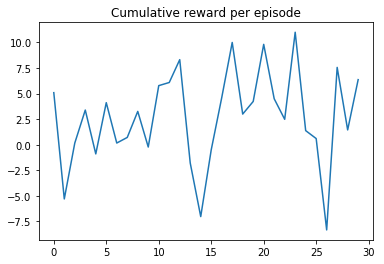

In [16]:
plt.title("Cumulative reward per episode")
plt.plot(stats.episode_rewards);
plt.savefig("./figures/{}_episoderewards.png".format(experiment_name))

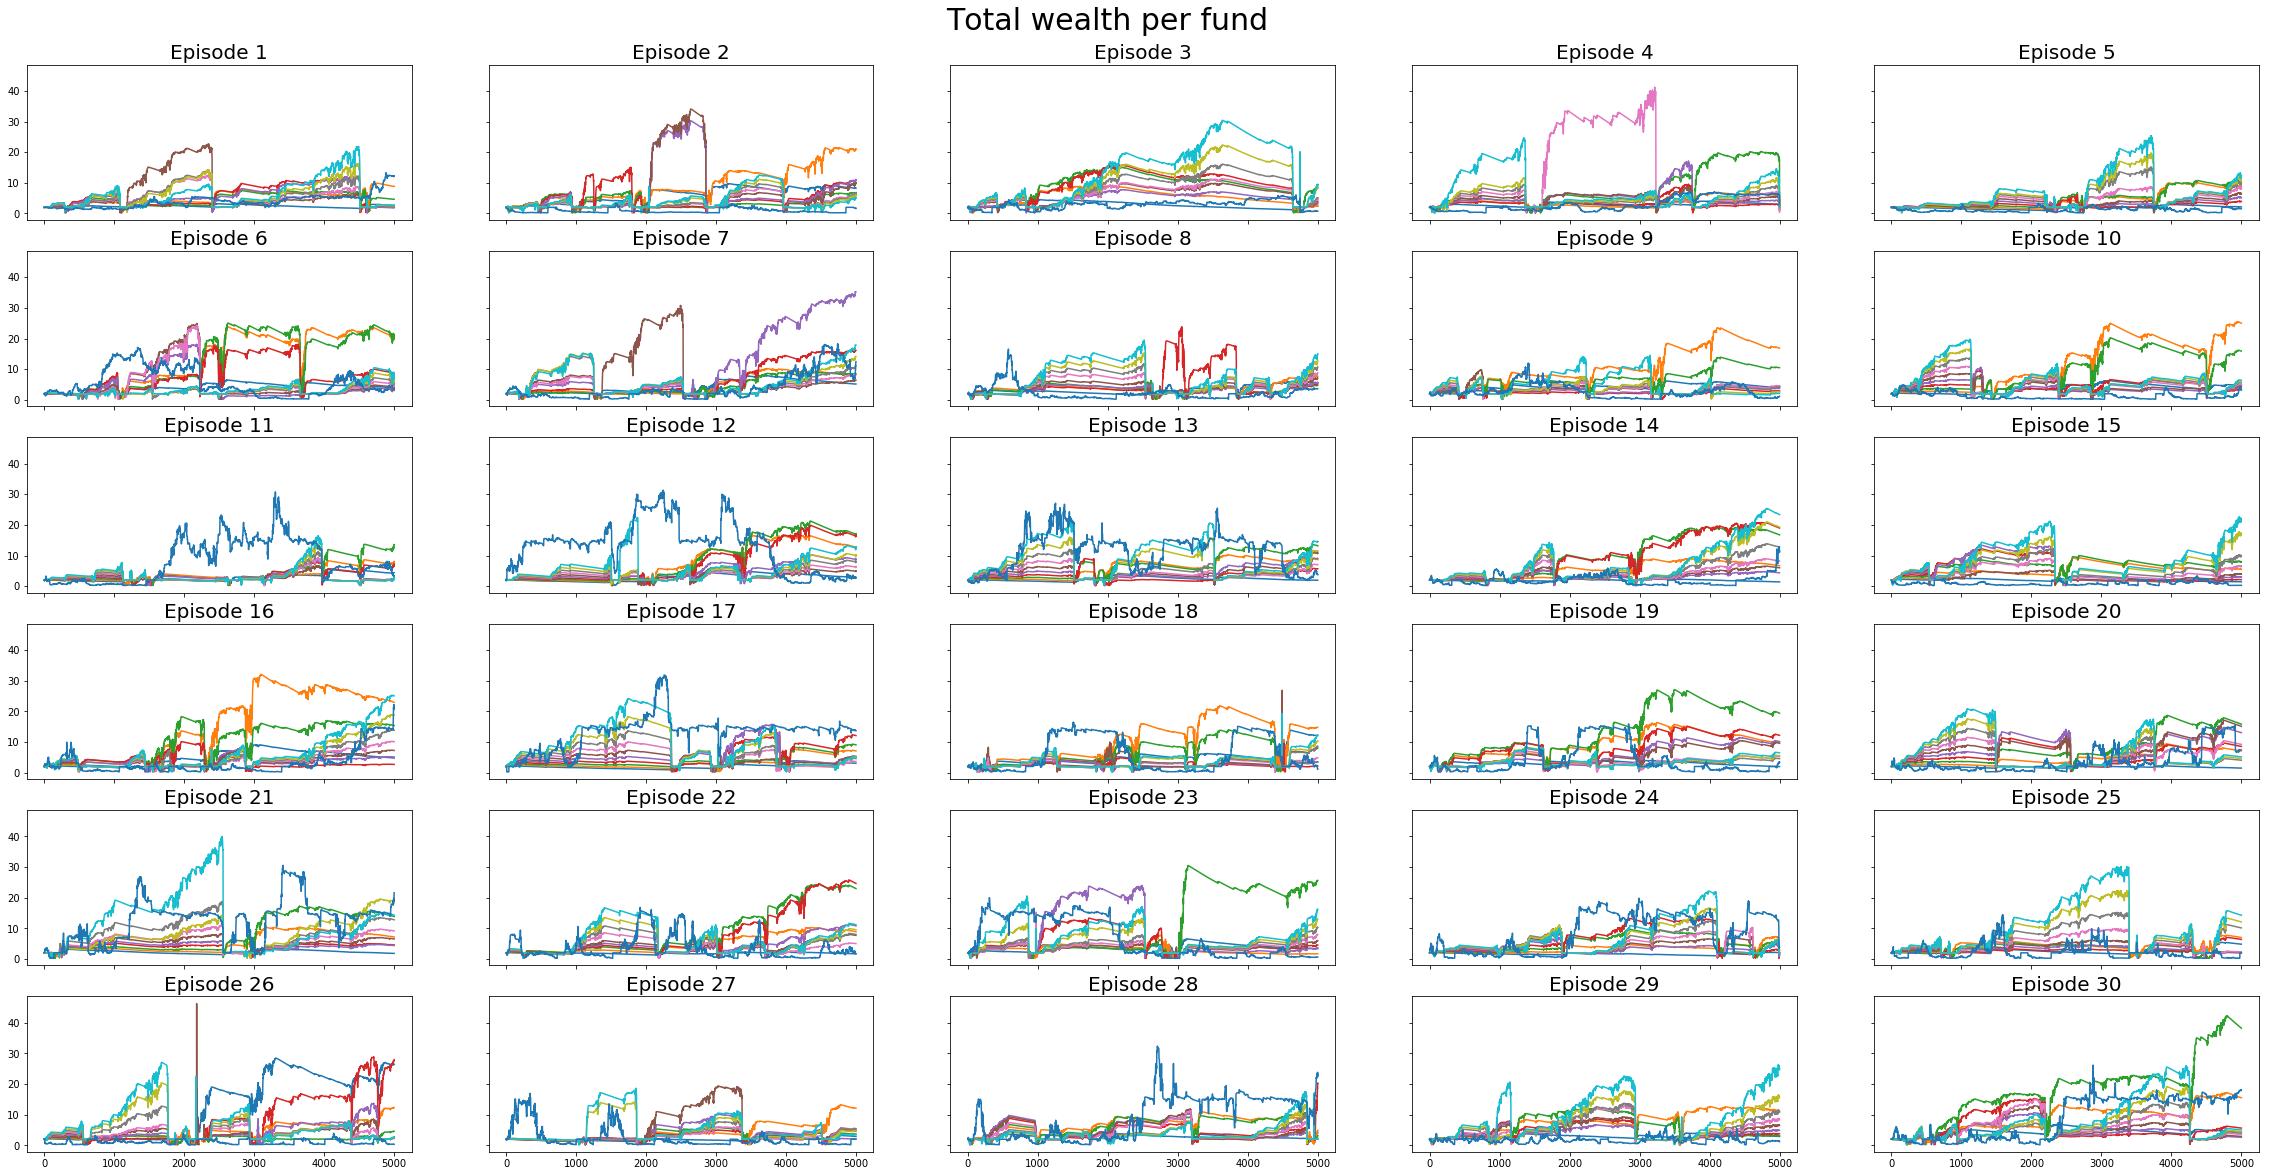

In [17]:
# assumes 10 episodes
fig, axes = plt.subplots(nrows=6, ncols=5, sharex=True, sharey=True,figsize=(40,20))

for i, ax in enumerate(axes.flatten()):
    ax.plot(funds_wealth_all_episodes[i])
    ax.set_title("Episode {}".format(i+1), {'fontsize':20})
    
fig.suptitle("Total wealth per fund", fontsize=30, y=0.92)

fig.savefig("./figures/{}.png".format(experiment_name));

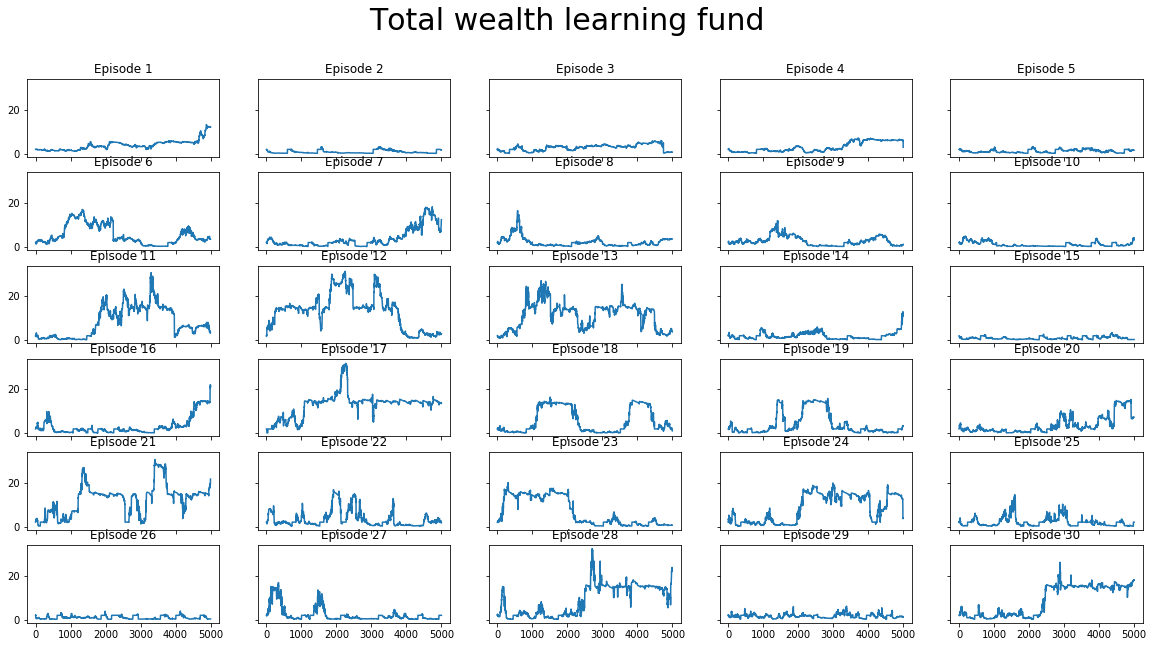

In [18]:
# assumes 10 episodes
fig, axes = plt.subplots(nrows=6, ncols=5, sharex=True, sharey=True,figsize=(20,10))

# define index of fund to plot (the last fund (-1) is our learning fund)
fund_index = -1

for i, ax in enumerate(axes.flatten()):
    episode = np.array(funds_wealth_all_episodes[i])
    ax.plot(episode.T[fund_index])
    ax.set_title("Episode {}".format(i+1), {'fontsize':12})
    
fig.suptitle("Total wealth learning fund", fontsize=30);
    
fig.savefig("./figures/{}_learning.png".format(experiment_name))

## Load model from checkpoint 

In [42]:
# look at saved checkpoints
#tf.train.get_checkpoint_state("./checkpoints/")

model_checkpoint_path: "./checkpoints/5000ts_10ep-ep14"
all_model_checkpoint_paths: "./checkpoints/5000ts_10ep-ep10"
all_model_checkpoint_paths: "./checkpoints/5000ts_10ep-ep11"
all_model_checkpoint_paths: "./checkpoints/5000ts_10ep-ep12"
all_model_checkpoint_paths: "./checkpoints/5000ts_10ep-ep13"
all_model_checkpoint_paths: "./checkpoints/5000ts_10ep-ep14"

In [45]:
## specify which checkpoint to load
#experiment_name = "5000ts_10ep"
#i_episode = 10
#
#start_time = time.time()
#
## Create the environment
#env = Env()
#
## first initialization of our learning fund
#learning_fund = LearningFund()
#
#saver = tf.train.Saver(max_to_keep=1)
#
#checkpoint = "./checkpoints/{}-ep{}".format(experiment_name,i_episode)
#
#experiment_name += "_continued"
#
#with tf.Session() as sess:
#    
#    saver.restore(sess, checkpoint)
#
#    stats_continued, funds_wealth_all_episodes_continued = actor_critic(env, policy_estimator, value_estimator,
#                                                                      num_episodes=5, discount_factor=0.95)
#    
#print("\nDuration: {} min".format((time.time() - start_time)/60))

INFO:tensorflow:Restoring parameters from ./checkpoints/5000ts_10ep-ep10
t: 50 @ Episode 1/5 (0.0)
Model saved in path: ./checkpoints/5000ts_10ep-ep0

t: 50 @ Episode 2/5 (0.046511776745319366)
Model saved in path: ./checkpoints/5000ts_10ep-ep1

t: 50 @ Episode 3/5 (0.04702062904834747)
Model saved in path: ./checkpoints/5000ts_10ep-ep2

t: 50 @ Episode 4/5 (0.0028090067207813263)
Model saved in path: ./checkpoints/5000ts_10ep-ep3

t: 50 @ Episode 5/5 (0.06456007808446884)
Model saved in path: ./checkpoints/5000ts_10ep-ep4


Duration: 0.13374995390574138 min


In [44]:
#len(funds_wealth_all_episodes)

5